In [1]:
import torch
from itertools import product
import pdb
import sys
from mnist import MNIST
# import cv2
import numpy as np

In [2]:
import torch.nn.functional as F

In [3]:
mndata = MNIST('./mnist/python-mnist/data/')
    # 载入数据
test_data_all, test_label_all = mndata.load_testing()
train_data_all, train_label_all = mndata.load_training()

test_data_all = torch.tensor(test_data_all).float()
train_label_all = torch.tensor(train_label_all)
test_label_all = torch.tensor(test_label_all)
train_data_all = torch.tensor(train_data_all).float()

In [4]:
# test_data, test_label = test_data_all[0:20], test_label_all[0:20]

In [4]:
train_data, train_label = train_data_all[0:100], train_label_all[0:100]

In [6]:
# 归一化数据，数据预处理一下
train_data = train_data / 255.

In [7]:
def get_feature(image):
    feature = image.view(1, 784)
    return feature

In [8]:
def model(feature, w1, w2, b1, b2):
#   feature = torch.cat((feature,torch.tensor(1.0).view(1,1)),1)
#   print(feature.shape)
    # 前向传播
    a1 = torch.mm(feature,w1) + b1
#     print('a1 ',a1.shape)
    z1 = torch.sigmoid(a1.float())
#     print('z1 ',z1.shape)
#     z1 = torch.cat((z1,torch.tensor(1.0).view(1,1)),1)
#     print('z1 ',z1.shape)
    a2 = torch.mm(z1, w2) + b2
#     print(a2)
    y = F.softmax(a2.float(), dim=1)
#     print(y)
#     y = torch.argmax(y, dim=1)
#     print(y)
    return y

In [9]:
res = model(train_data[1].view(1,784), w1,w2,b1,b2)
res

NameError: name 'w1' is not defined

In [10]:
def label2ground_truth(image_label):
    gt = torch.ones(10,10)
    gt = gt*-1.0
    #for label in image_label:
    for i in range(0,10):
        gt[i,i]=float(image_label[i])
    return gt

In [11]:
def one_hot(gt):
    gt_vector = torch.ones(1,10)
    gt_vector *= -0.1
    gt_vector[0,gt] = 0.9
    return gt_vector

In [12]:
one_hot(train_label[3])

tensor([[-0.1000,  0.9000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000,
         -0.1000, -0.1000]])

In [2]:
def cross_entropy(y,t):
    pass
    

In [13]:
def loss(x, t):
    y = model(x,w1,w2,b1,b2)
    return cross_entropy(y,t)

In [14]:
def get_acc(image_data,image_label,w1,w2,b1,b2, start_i,end_i):
    correct=0
    for i in range(start_i,end_i):
             #print(image_label[i])
             #y = model(get_feature(image_data[i]),weights)
        feature = get_feature(image_data[i])
        y = model(feature,w1,w2,b1,b2)
             #pdb.set_trace()
        gt = image_label[i]
             #pred=torch.argmin(torch.abs(y-gt)).item()
        pred = torch.argmax(y, dim=1)
             #pred = torch.argmin((torch.abs(y-1))).item()
             #print("图像[%s]得分类结果是:[%s]"%(gt,pred))
        if gt==pred:
            correct+=1
             
    #print("acc=%s"%(float(correct/20.0)))
    return  float(correct/float(end_i-start_i))

# print(image_train[1])
# y1 = predict(image_train[0:10].view(10,784))
# print(image_train[0:10].shape)
# t = np.argmax(y1.detach().numpy(), axis=0)
# print(y1)
# print(t)
def accuracy(image_data, image_label, w1, b1, w2, b2):
    acc = 0
    output = predict(image_data, w1, b1, w2, b2)
    y = torch.argmax(output, dim=1)
    cnt = torch.sum(y == image_label)
    acc = cnt.data.item() / image_data.shape[0]
    return acc


In [23]:
def train_model(image_data, image_label, w1, w2,b1,b2, lr = 0.05):
    loss_value_before=1000000000000000.
    loss_value=10000000000000.
    
    for epoch in range(500):
        loss_value_before = loss_value
        loss_value = 0
        for i in range(0,80):
            feature = get_feature(image_data[i])
            y = model(feature, w1, w2,b1,b2)
            gt = image_label[i]
            gt_vector = one_hot(gt).float()
            
#             print(gt_vector)
            loss = 0.5 * torch.sum((y-gt_vector).mul(y-gt_vector)).float()
#             loss = F.cross_entropy(y, image_label[i:i+1])
            loss_value += loss.data.item()
            loss.backward()
            
            w1.data.sub_(w1.grad.data*lr)
            w2.data.sub_(w2.grad.data*lr)
            b1.data.sub_(b1.grad.data*lr)
            b2.data.sub_(b2.grad.data*lr)
            w1.grad.data.zero_()
            w2.grad.data.zero_()
            b1.grad.data.zero_()
            b2.grad.data.zero_()
            
        train_acc = get_acc(image_data, image_label, w1,w2,b1,b2,0,80)
        test_acc = get_acc(image_data,image_label,w1,w2,b1,b2,80,100)
        print("epoch=%s,loss=%s/%s,train/test_acc=%s/%s,"%(epoch,loss_value,loss_value_before,train_acc,test_acc))
    
    return w1 ,w2,b1,b2

In [25]:
if __name__ == '__main__':

    w1 = torch.randn(784, 50, requires_grad=True)
    w2 = torch.randn(50, 10, requires_grad=True)
    b1 = torch.zeros(1, 50,requires_grad=True)
    b2 = torch.zeros(1, 10, requires_grad=True)
    
    w1, w2, b1, b2 = train_model(train_data, train_label, w1, w2,b1,b2)
    
    correct = 0
    for i in range(0,100):
        feature = get_feature(train_data[i])
        y = model(feature, w1, w2,b1,b2)
        gt = train_label[i]
        pred = torch.argmax(y, dim=1)
        if pred == gt:
            correct += 1
    
    print("acc: ", correct / float(100))

epoch=0,loss=61.869082406163216/10000000000000.0,train/test_acc=0.175/0.15,
epoch=1,loss=56.90801456198096/61.869082406163216,train/test_acc=0.225/0.15,
epoch=2,loss=54.26785750314593/56.90801456198096,train/test_acc=0.25/0.25,
epoch=3,loss=51.55289439484477/54.26785750314593,train/test_acc=0.2875/0.25,
epoch=4,loss=48.25546778738499/51.55289439484477,train/test_acc=0.2875/0.35,
epoch=5,loss=46.44975093379617/48.25546778738499,train/test_acc=0.3/0.4,
epoch=6,loss=45.03319676220417/46.44975093379617,train/test_acc=0.3125/0.4,
epoch=7,loss=43.4773994833231/45.03319676220417,train/test_acc=0.35/0.45,
epoch=8,loss=41.52253856882453/43.4773994833231,train/test_acc=0.375/0.4,
epoch=9,loss=38.59670163691044/41.52253856882453,train/test_acc=0.4125/0.45,
epoch=10,loss=35.87777064740658/38.59670163691044,train/test_acc=0.475/0.45,
epoch=11,loss=33.52701535075903/35.87777064740658,train/test_acc=0.5/0.5,
epoch=12,loss=31.861690402030945/33.52701535075903,train/test_acc=0.525/0.45,
epoch=13,loss=3

epoch=106,loss=10.5960896871984/10.657349981367588,train/test_acc=0.875/0.55,
epoch=107,loss=10.530829399824142/10.5960896871984,train/test_acc=0.875/0.55,
epoch=108,loss=10.46110600978136/10.530829399824142,train/test_acc=0.875/0.55,
epoch=109,loss=10.386524379253387/10.46110600978136,train/test_acc=0.875/0.55,
epoch=110,loss=10.306819930672646/10.386524379253387,train/test_acc=0.875/0.55,
epoch=111,loss=10.221930585801601/10.306819930672646,train/test_acc=0.8875/0.55,
epoch=112,loss=10.132050797343254/10.221930585801601,train/test_acc=0.8875/0.55,
epoch=113,loss=10.03764121234417/10.132050797343254,train/test_acc=0.8875/0.55,
epoch=114,loss=9.939371198415756/10.03764121234417,train/test_acc=0.8875/0.55,
epoch=115,loss=9.837966792285442/9.939371198415756,train/test_acc=0.8875/0.55,
epoch=116,loss=9.734003227204084/9.837966792285442,train/test_acc=0.8875/0.55,
epoch=117,loss=9.627736665308475/9.734003227204084,train/test_acc=0.9/0.55,
epoch=118,loss=9.519068405032158/9.627736665308475,

epoch=212,loss=5.338437654078007/5.342690449208021,train/test_acc=0.975/0.8,
epoch=213,loss=5.334343444555998/5.338437654078007,train/test_acc=0.975/0.8,
epoch=214,loss=5.330396220088005/5.334343444555998,train/test_acc=0.975/0.8,
epoch=215,loss=5.326584868133068/5.330396220088005,train/test_acc=0.975/0.8,
epoch=216,loss=5.322898708283901/5.326584868133068,train/test_acc=0.975/0.8,
epoch=217,loss=5.319327630102634/5.322898708283901,train/test_acc=0.975/0.8,
epoch=218,loss=5.315863333642483/5.319327630102634,train/test_acc=0.975/0.8,
epoch=219,loss=5.312496554106474/5.315863333642483,train/test_acc=0.975/0.8,
epoch=220,loss=5.309219777584076/5.312496554106474,train/test_acc=0.975/0.8,
epoch=221,loss=5.306024331599474/5.309219777584076,train/test_acc=0.975/0.8,
epoch=222,loss=5.302903115749359/5.306024331599474,train/test_acc=0.975/0.8,
epoch=223,loss=5.299848940223455/5.302903115749359,train/test_acc=0.975/0.8,
epoch=224,loss=5.29685452580452/5.299848940223455,train/test_acc=0.975/0.8,


epoch=318,loss=4.122895579785109/4.125406712293625,train/test_acc=1.0/0.8,
epoch=319,loss=4.1205292493104935/4.122895579785109,train/test_acc=1.0/0.8,
epoch=320,loss=4.118294309824705/4.1205292493104935,train/test_acc=1.0/0.8,
epoch=321,loss=4.116178669035435/4.118294309824705,train/test_acc=1.0/0.8,
epoch=322,loss=4.114171992987394/4.116178669035435,train/test_acc=1.0/0.8,
epoch=323,loss=4.112265400588512/4.114171992987394,train/test_acc=1.0/0.8,
epoch=324,loss=4.110450658947229/4.112265400588512,train/test_acc=1.0/0.8,
epoch=325,loss=4.108720451593399/4.110450658947229,train/test_acc=1.0/0.8,
epoch=326,loss=4.107068549841642/4.108720451593399,train/test_acc=1.0/0.8,
epoch=327,loss=4.105489362031221/4.107068549841642,train/test_acc=1.0/0.8,
epoch=328,loss=4.10397744551301/4.105489362031221,train/test_acc=1.0/0.8,
epoch=329,loss=4.102528419345617/4.10397744551301,train/test_acc=1.0/0.8,
epoch=330,loss=4.101137563586235/4.102528419345617,train/test_acc=1.0/0.8,
epoch=331,loss=4.09980155

epoch=428,loss=4.051461145281792/4.051681287586689,train/test_acc=1.0/0.85,
epoch=429,loss=4.051243290305138/4.051461145281792,train/test_acc=1.0/0.85,
epoch=430,loss=4.051027599722147/4.051243290305138,train/test_acc=1.0/0.85,
epoch=431,loss=4.050814177840948/4.051027599722147,train/test_acc=1.0/0.85,
epoch=432,loss=4.050602663308382/4.050814177840948,train/test_acc=1.0/0.85,
epoch=433,loss=4.050393242388964/4.050602663308382,train/test_acc=1.0/0.85,
epoch=434,loss=4.050185717642307/4.050393242388964,train/test_acc=1.0/0.85,
epoch=435,loss=4.049980312585831/4.050185717642307,train/test_acc=1.0/0.85,
epoch=436,loss=4.049776904284954/4.049980312585831,train/test_acc=1.0/0.85,
epoch=437,loss=4.049575384706259/4.049776904284954,train/test_acc=1.0/0.85,
epoch=438,loss=4.049375873059034/4.049575384706259,train/test_acc=1.0/0.85,
epoch=439,loss=4.049178052693605/4.049375873059034,train/test_acc=1.0/0.85,
epoch=440,loss=4.048982195556164/4.049178052693605,train/test_acc=1.0/0.85,
epoch=441,lo

In [102]:
res = model(train_data[7].view(1,784), w1,w2,b1,b2)
pred = torch.argmax(res, dim=1)
print(pred)
print(train_label[7])


tensor([3])
tensor(3)


In [92]:
import matplotlib.pyplot as plt

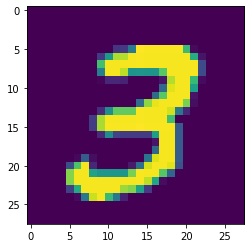

In [103]:
plt.imshow(train_data[7].detach().numpy().reshape(28,28))
plt.show()

In [ ]:
# def train_model(image_train, train_label, image_test, test_label, w1, w2, b1, b2, lrt=0.01):    
#     iter_nums = 1000
#     train_size = image_train.shape[0]
# #     batch_size = 10

#     train_loss_list = []
#     train_acc_list = []
#     test_acc_list = []
    
#     one_hot_train = onehot(train_label)
#     one_hot_test = onehot(test_label)

    
#     for i in range(iter_nums):
#         loss_last_epoch = 0
#         train_acc_epoch = 0
#         test_acc_epoch = 0
        
#         batch_mask = np.random.choice(100, 10)
#         train_epoch = image_train[batch_mask]
#         label_epoch = one_hot_train[batch_mask]

# #         for idx, img in enumerate(image_train):
#         y = predict(train_epoch, w1, b1, w2, b2)
#     #         print(y)
#         loss = torch.sum(0.5 * torch.mul((y - label_epoch), (y - label_epoch)))
#         train_loss_list.append(loss)
#         print('loss is ',loss.data.item())
#             # 反向传播计算梯度
#         loss.backward()
#         w1.data.sub_(w1.grad.data * lrt)
#         w2.data.sub_(w2.grad.data * lrt)
#         b1.data.sub_(b1.grad.data * lrt)
#         b2.data.sub_(b2.grad.data * lrt)
            
#         w1.grad.data.zero_()
#         b1.grad.data.zero_()
#         w2.grad.data.zero_()
#         b2.grad.data.zero_()

#         train_acc_epoch = accuracy(image_train, train_label, w1, b1, w2, b2)
#         test_acc_epoch = accuracy(image_test, test_label, w1, b1, w2, b2)

#         train_acc_list.append(train_acc_epoch)
#         test_acc_list.append(test_acc_epoch)
#         print('train acc, test acc  ' + str(test_acc_epoch) + ', ' + str(test_acc_epoch))
# #         print('loss is ', loss_last_epoch / 10)
        
#     return w1, w2, b1, b2

In [ ]:
# output1 = predict(image_test, w1,b1,w2,b2)
# print(output1)
# y = torch.argmax(output1, dim=1)
# gt = onehot(test_label)
# # print(gt)
# # cnt = torch.sum(y == test_label)
# # print('cnt = ', cnt )
# # print(image_test.shape[0])
# # print(cnt.data.item() / image_test.shape[0])
# # acc = accuracy(image_test, test_label, w1, b1, w2, b2)
# loss = torch.sum(0.5 * (output1 - gt).mul(output1 - gt))
# print(loss)
# loss.backward()

# # print(acc)
# # print(loss)
# print('w1 grad', sum(w1.grad))
# print('shape of grad w1',w1.grad.shape)
# print('w1 size',b1.shape)
# # print(output1)